# Zero coupon curve building

## 1. Linear swap rate

Etant donné le taux forward $F_1$ entre $T_1$ et $T_2$, on a $$\frac{P(0,T_1)}{P(0,T_2)} = 1 + F_1*(T_2-T_1)$$

Si on a des valeurs de swap rate pour différentes maturités, par exemple: $S_{2Y} = 2,7\% , S_{5Y} = 3,6\%, S_{10Y} = 4,6\%$

On utilise cela et la formule du taux swap $$102,7 P(0,T_2) = 100 -2,7P(0,T_1)$$ de laquelle on déduit les valeurs de $P(0,T_1)$ et $P(0,T_2)$. 

Donc $$P(0,T_1) = \frac{100}{\frac{100+S_{2Y}}{1+F_1} + S_{2Y}}$$

Ensuite, on considère que le taux swap est linéaire entre deux dates où il est connu. Ainsi pour calculer $P(0,T_3)$, on procède ainsi: $$S_{T_3} = S_{T_2} + (T_3-T_2)* \frac{S_{T_5}-S_{T_2}}{T_5-T_2} = 3 \%$$
Et enfin $$103 *P(0,T_3) = 100 - 3 \sum_{i=1}^2 P(0,T_i)$$
Et ainsi de suite pour les zero coupons de maturités $T_4$ et $T_5$

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot2D(x,y,ylabel,title,z=[],zlabel=''):
    plt.figure()
    plt.xlabel('T')
    plt.title(title)
    plt.plot(x,y,label=ylabel)
    if z != []:
        plt.plot(x,z,label=zlabel)
    plt.legend()
    plt.show()

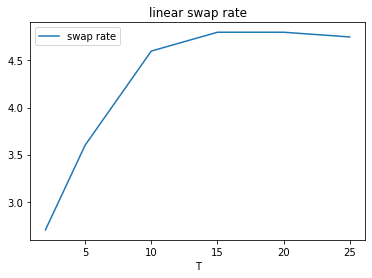

In [48]:
Swap_rates = [2.7,3.6,4.6,4.8,4.8,4.75]
dates = [2,5,10,15,20,25]
forward_1 = 0.05

#construction linéaire du taux swap

linear_swap = [Swap_rates[0]]
for i in range(1,len(dates)):
    coef = (Swap_rates[i]-Swap_rates[i-1])/(dates[i]-dates[i-1])
    
    for j in range(dates[i-1]+1,dates[i]):
        linear_swap.append(Swap_rates[i-1] + coef*(j-dates[i-1]))
    linear_swap.append(Swap_rates[i])

plot2D(np.arange(dates[0],dates[-1]+1),linear_swap,'swap rate','linear swap rate')

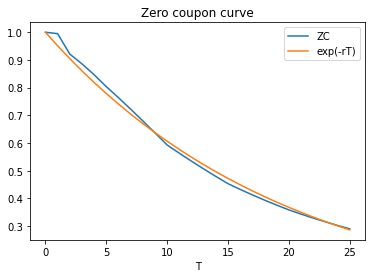

In [71]:
# calcul des zeros coupons à chaque année

P1 = 100/((100+Swap_rates[0])/(1+forward_1) + Swap_rates[0])
ZC = [1,P1]

for i in range(len(linear_swap)):
    Pi = (100 - linear_swap[i]*sum(ZC))/(100 + linear_swap[i])
    ZC.append(Pi)

T = np.arange(0,26)
plot2D(T,ZC,'ZC','Zero coupon curve',[np.exp(-0.05*t) for t in T],'exp(-rT)')

## 2. Constant forward rate

On considère cette fois que l'on connait le taux forward annuel aux dates $T_2,T_5,T_{10}$ et que celui ci est constant entre $T_2$ et $T_4$, puis entre $T_5$ et $T_9$.

Si l'on connaît $P(0,T_5)$ par exemple, la deuxième étape consiste en les calculs suivants (si le temps écoulé entre chaque coupon est constant egale à $\Delta$)
$$P(0,T_6) = \frac{P(0,T_5)}{\Big(1+F\Delta\Big)} \quad P(0,T_7) = \frac{P(0,T_5)}{\Big(1+F\Delta\Big)^2}$$ et ainsi de suite.

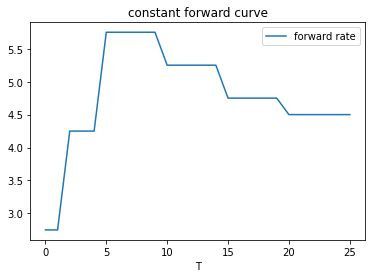

In [39]:
dates = [1,2,5,10,15,20,25]
forward = [2.75,4.25,5.75,5.25,4.75,4.5]

#construction du taux forward constant
constant_forward = [forward[0]]
for i in range(1,len(dates)):
    for j in range(dates[i-1],dates[i]):
        constant_forward.append(forward[i-1])
constant_forward.append(forward[-1])


plot2D(np.arange(0,dates[-1]+1),constant_forward,'forward rate','constant forward curve')

!!Méthode à revoir!

-----
On fixe une structure de tenors sur laquelle on a des données de taux swap $T_1,T_2,T_3...,T_N$

**Etape 1:** Récupérer la courbe des taux swaps ou certains points et interpoler si besoin. Si on connait les taux swap $(S(T_i))_{i=1,n}$, les taux swap manquants seront: $$S(T_j) = \frac{(T_{i+1}-T_j)*S(T_i) \ + \ (T_j-T_i)*S(T_{i+1})}{T_{i+1}-T_i}$$

**Etape 2:** Calcul des zero coupons pour les dates du tenor. En commencant par $i=1$, on itère en résolvant à chaque étape $$\Big(100 + S(T_i)*100 \Delta_i \Big)*P(0,T_i) = 100 - 100*S(T_i) \sum_{j=1}^{i-1} P(0,T_j) \Delta_j $$

**Etape 3:** On calcule le taux forward entre $T_i$ et $T_{i+1}$:

$$\forall i \in [|0,N-1|], \quad F(0,T_i,T_{i+1}) = \frac{1}{T_{i+1}-T_i} \Big( \frac{P(0,T_i)}{P(0,T_{i+1})} -1\Big)$$

On obtient ainsi une courbe du taux forward en interpolant les points de la courbes calculés ci dessus.

**Etape 4:** On calcule les zero coupons à des dates $t$ intermédiaires 
$$t \in [T_i,T_{i+1}], \quad P(0,t) = P(0,T_i) \Big(1 + F(0,T_i,t)*(t-T_i) \Big)^{-1}$$ où $F(0,T_i,t)$ est calculé avec la méthode d'interpolation choisie à l'étape précédente.

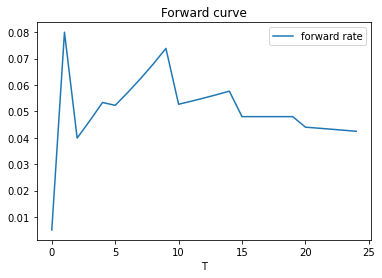

In [77]:
#calcul des taux forward

forward = [(ZC[i]/ZC[i+1] - 1) for i in range(25)]

plot2D(range(25),forward,'forward rate','Forward curve')

In [80]:
#courbe zero coupon pour tenor 0,1,...,T_max
def zero_coupon(t,T_max,forward):
    i = int(t)
    Pi = ZC[i]
    if(i+1==len(forward)):
        Fi = forward[i]
    else:
        Fi = forward[i]*(i+1-t) + forward[i+1]*(t-i)
    return Pi/(1 + Fi*(t-i))


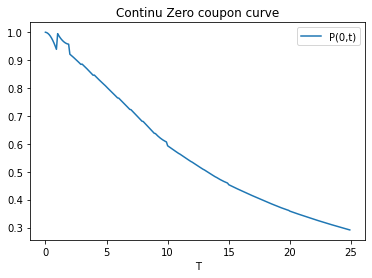

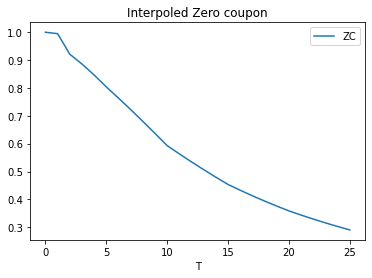

In [89]:
T = np.arange(0,25,0.1)
ZC_continu = [zero_coupon(t,25,forward) for t in T]

plot2D(T,ZC_continu,'P(0,t)','Continu Zero coupon curve')
plot2D(np.arange(0,26),ZC,'ZC','Interpoled Zero coupon')

## 3. Linear forward rate

Le but de cette méthode est de construire une courbe du taux forward simple de sorte que ce soit une courbe linéaire par morceaux. Sur chaque segment $[T_i,T_{i+1}]$, on cherche un taux forward de la forme $F_i(t) = F_0^{(i)} + K_i * t$. Il faut donc 2 contraintes sur chaque segment pour déterminer la courbe.

**(1)** Pour que la courbe soit continue, il faut que la première extrémité de chaque segment coïncide avec la seconde du segment précèdent. Soit $F_{i-1}(T_i) = F_i(T_i)$

**(2)** $$F_i(T_{i+1})= F_0 + K_i*T_i$$

Une fois la courbe des taux forward construite, on calcule le prix des zeros coupons suivant: $$F_i(t) = F_0^{(i)} + K_i * t = \frac{1}{t-T_i} \Big( \frac{P(0,T_i)}{P(0,t)} -1 \Big) \quad, t \in [T_i,T_{i+1}]$$

Par exemple, $$P(0,T_1) = \Big( 1+ F_0(T_1)*T_1 \Big)^{-1} \\
P(0,T_2) = P(0,T_1) \Big( 1+ F_1(T_2)*(T_2 - T_1) \Big)^{-1}$$

Considérons que l'on a calculé la courbe des zeros coupons jusqu'à la date $T_5$ et que l'on a la courbe forward décrite ci-dessus entre $T_5$ et $T_10$. Alors on va calculer le prix du zero coupon $P(0,T_{10})$ comme ceci:
$$4,6 \sum_{i=6}^9 \frac{P(0,T_i)}{P(0,T_5)} + 104,6 \frac{P(0,T_{10})}{P(0,T_5)} = \frac{1}{P(0,T_5)} \Big(100 - 4,6 \sum_{i=1}^5 P(0,T_i) \Big) \\
\iff 4,6 \sum_{i=6}^9 \frac{1}{(1+F_0^{(5)}+K_5)...(1+F_0^{(i-1)} + K_{i-1})} + 104,6 \frac{P(0,T_{10})}{P(0,T_5)} = \frac{1}{P(0,T_5)} \Big(100 - 4,6 \sum_{i=1}^5 P(0,T_i) \Big)$$

## Zero coupon Interpolation 